In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import matplotlib.pyplot  as plt
%matplotlib inline

# Part A
### Train one VAE in this configuration on both datasets:#
- 2D latent variables z with a standard normal prior p(z) = N (z; 0, I).

- An approximate posterior q θ (z|x) = N (z; μ θ (x), Σ θ (x))), where μ θ (x) is a mean
vector and Σ θ (x) is a diagonal covariance matrix

- A decoder p θ (x|z) = N (x; μ θ (z), Σ θ (z)), where μ θ (z) is a mean vector and Σ θ (z) is
a diagonal covariance matrix

### and train another in this configuration, also on both datasets:
- Prior and approximate posterior identical to above

- A decoder p θ (x|z) = N (x; μ θ (z), σ θ 2 (z)I), where μ θ (z) is a mean vector and σ θ 2 (z) is
a scaler.

### Deliverables for all 4 choices of datasets and models:

- Loss curves and final loss, in bits per dimension. Include separate curves and numbers
for the full ELBO, the KL term E x E z∼q(z|x) [KL(q(z|x)kp(z))], the decoder term
E x E z∼q(z|x) [−logp(x|z)].

- Samples from the full generation path (z ∼ p(z), x ∼ p(x|z)) and without decoder
noise (z ∼ p(z), x = μ(z)). Draw both in the same plot.

- Is the VAE using the latent code? How do you know? If it does, what about the data
does it capture qualitatively?

In [0]:
BATCHSIZE = 1000

In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * 
                         [[5.0, 1.0]]).dot([[np.sqrt(2)/2, np.sqrt(2)/2], 
                                            [-np.sqrt(2)/2, np.sqrt(2)/2]])


In [4]:
data_1 = sample_data_1()
data_2 = sample_data_2()

print("data 1 shape:",data_1.shape)
print("data 1 example:", data_1[0])
print("data 2 shape:",data_2.shape)
print("data 2 example:", data_2[0])

data 1 shape: (100000, 2)
data 1 example: [9.82026173 2.40015721]
data 2 shape: (100000, 2)
data 2 example: [6.95391301 8.51982076]


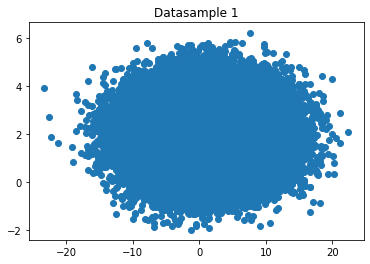

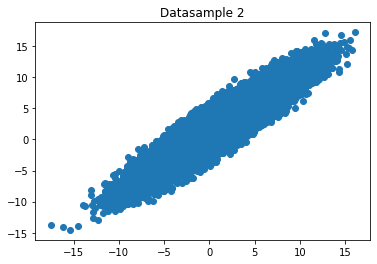

In [5]:
plt.scatter(data_1[:,0], data_1[:,1])
plt.title("Datasample 1")
plt.show()
plt.scatter(data_2[:,0], data_2[:,1])
plt.title("Datasample 2")
plt.show()

Split the data into train and test

In [6]:
data_1_train = data_1[:80000]
data_1_test = data_1[80000:]

data_2_train = data_2[:80000]
data_2_test = data_2[80000:]

print("train shape: ", data_1_train.shape)
print("test shape: ", data_1_test.shape)

train shape:  (80000, 2)
test shape:  (20000, 2)


In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, x, transform=None):
      self.x = torch.from_numpy(x).float()
      self.transform = transform
      
  def __getitem__(self, index):
      y = self.x[index]
      
      if self.transform:
          y = self.transform(y)
      return y
  
  def __len__(self):
      return len(self.x)

Put the data into pytorch dataloader

In [0]:
train_ds_1 = MyDataset(data_1_train)
test_ds_1 = MyDataset(data_1_test)
train_ds_2 = MyDataset(data_2_train)
test_ds_2 = MyDataset(data_2_test)

In [0]:
train_loader_1 = torch.utils.data.DataLoader(train_ds_1, batch_size=BATCHSIZE, shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_ds_1, batch_size=BATCHSIZE,shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_ds_2, batch_size=BATCHSIZE,shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(test_ds_2, batch_size=BATCHSIZE,shuffle=True)

In [0]:
class VAE(nn.Module):
  def __init__(self, scalar=False, latent_variables=2,): 
    super(VAE,self).__init__()
    self.latent_variables = latent_variables
    self.scalar= scalar
    self.out_features = latent_variables + 1 if scalar else 2 * latent_variables

    self.encoder = nn.Sequential(
        nn.Linear(in_features=latent_variables, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=(self.latent_variables*2))
    )
        
    self.decoder = nn.Sequential(
        nn.Linear(in_features=self.latent_variables, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=self.out_features)
    )

  def reparametrisation(self, mu, log_var):
    # This is needed because you can not backprob through a random node
    # N(mu, sigma) = mu + epsilon * sigma, where epsilon ~ N(0, 1)
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps*std  
  
  def sample(self, z):
    x_sample = self.decoder(z)
    x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
    without_decoder_noise = x_mu
    full_generation_path = self.reparametrisation(x_mu, x_log_var)
    return full_generation_path, without_decoder_noise

  def log_normal(self, x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

  def loss(self, x, mu, log_var, x_mu, x_log_var):
    # print("x:", x.shape, "mu:", mu.shape, "log_var:", log_var.shape, "x_mu:", x_mu.shape, "x_log_var:", x_log_var.shape)
    likelihood = torch.sum(-self.log_normal(x, x_mu, x_log_var), dim=1)
  
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1))
    
    NLL = torch.mean(likelihood)/np.log(2)/2
    
    ELBO = NLL + KLD    

    return ELBO, KLD, NLL

  def forward(self, x):
    mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)

    z = self.reparametrisation(mu, log_var)

    x_sample = self.decoder(z)

    if self.scalar:
      x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
      x_log_var = torch.ones_like(x_mu) * x_log_var
    
    else:
      x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)

    return mu, log_var, x_mu, x_log_var



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
vae = VAE().to(device)
print(vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [0]:
def train_vae(vae, train_loader, test_loader, epochs=50):
  EPOCH = epochs
  train_loss = []
  train_kld = []
  train_nll = []

  val_loss = []
  val_kld = []
  val_nll = []
  j = 0
  for epoch in range(EPOCH):
    vae.train()
    start_time = time.time()
    for i, x in enumerate(train_loader, 0):
      x = x.to(device).float()
    
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      mu, log_var, x_mu, x_log_var = vae(x)

      loss, kld, nll = vae.loss(x, mu, log_var, x_mu, x_log_var)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      train_kld.append(kld.item())
      train_nll.append(nll.item())

    # print statistics
    
    with torch.set_grad_enabled(False):
      for val_batch in test_loader:
        x_val = val_batch.to(device).float()
        mu, log_var, x_mu, x_log_var =  vae(x_val)
        v_loss, v_kld, v_nll = vae.loss(x_val, mu, log_var, x_mu, x_log_var)

        val_loss.append(v_loss.item())
        val_kld.append(v_kld.item())
        val_nll.append(v_nll.item())
      sec = (time.time() - start_time)
    if (epoch % 10 == 0):
      print("--- epoch:", epoch, "sec:", sec, "---")
      print("loss:", loss.item(), "val loss:", v_loss.item(), 
            "KLD:", kld.item(), "val KLD:", v_kld.item(),
            "NLL:", nll.item(), "val NNL:", v_nll.item(), "\n")
  return train_loss, train_kld, train_nll, val_loss, val_kld, val_nll

In [0]:
def plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll): 
  f, axarr = plt.subplots(1,3, figsize=(15,5))

  ax = axarr[0]
  ax.set_title('ELBO')
  ax.plot(train_loss, label = "ELBO_train_loss")
  ax.plot(np.arange(0, len(train_loss),(len(train_loss)/len(val_loss))),val_loss, label = "ELBO_val_loss")

  ax = axarr[1]
  ax.set_title('KL')
  ax.plot(train_kld, label = "kld_train_loss")
  ax.plot(np.arange(0, len(train_kld),(len(train_kld)/len(val_kld))),val_kld, label = "KL_val_loss")

  ax = axarr[2]
  ax.set_title('NLL')
  ax.plot(train_nll, label = "NLL_train_loss")
  ax.plot(np.arange(0, len(train_nll),(len(train_nll)/len(val_nll))),val_nll, label = "NLL_val_loss")
  plt.show()

In [0]:
def plot_samples(vae, plot_data):
  f, axarr = plt.subplots(1,2, figsize=(15,5))
  vae.eval()
  z = torch.randn(10000, 2)
  full_generation_path, without_decoder_noise = vae.sample(z)
  full_generation_path = full_generation_path.data.numpy() 
  without_decoder_noise = without_decoder_noise.data.numpy()
  mu, log_var, x_mu, x_log_var = vae.forward(plot_data.float())
  z = vae.reparametrisation(x_mu, x_log_var).detach().numpy()

  ax = axarr[0]
  ax.scatter(plot_data[:,0].data.numpy(),plot_data[:,1].data.numpy())
  ax.scatter(full_generation_path[:,0],full_generation_path[:,1])
  ax.set_title('full_generation_path')
  ax.axis('equal')

  ax = axarr[1]
  ax.scatter(plot_data[:,0].data.numpy(),plot_data[:,1].data.numpy())
  ax.scatter(without_decoder_noise[:,0], without_decoder_noise[:,1])
  ax.set_title('without_decoder_noise')
  ax.axis('equal')

  plt.show()

In [0]:
learning_rate = lr=3e-4

### Sample 1 and no scalar

--- epoch: 0 sec: 0.8107254505157471 ---
loss: 6.975581645965576 val loss: 7.392123222351074 KLD: 0.7445237040519714 val KLD: 0.8638184666633606 NLL: 6.231058120727539 val NNL: 6.528304576873779 

--- epoch: 10 sec: 0.6698663234710693 ---
loss: 3.2010154724121094 val loss: 3.2125654220581055 KLD: 0.011709854006767273 val KLD: 0.011874686926603317 NLL: 3.189305543899536 val NNL: 3.200690746307373 

--- epoch: 20 sec: 0.7548668384552002 ---
loss: 3.2077457904815674 val loss: 3.2301743030548096 KLD: 0.001145065762102604 val KLD: 0.0012511201202869415 NLL: 3.2066006660461426 val NNL: 3.2289230823516846 

--- epoch: 30 sec: 0.8569967746734619 ---
loss: 3.1676712036132812 val loss: 3.219588279724121 KLD: 0.00021786072466056794 val KLD: 0.00022290962806437165 NLL: 3.1674532890319824 val NNL: 3.219365358352661 

--- epoch: 40 sec: 0.9559409618377686 ---
loss: 3.1840052604675293 val loss: 3.1685988903045654 KLD: 0.000283108267467469 val KLD: 0.0002505292068235576 NLL: 3.1837222576141357 val NNL

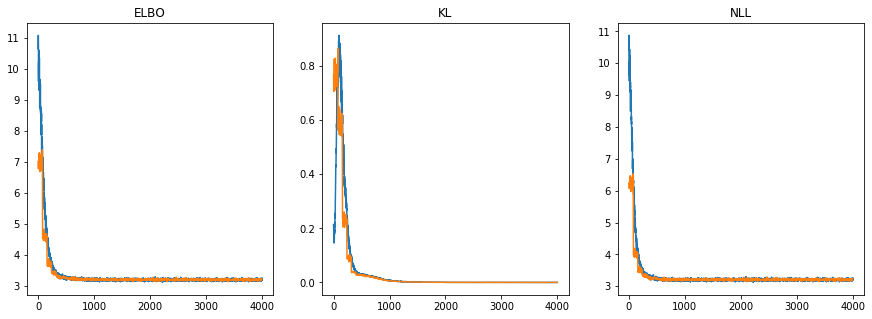

In [17]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate, weight_decay=0.0001)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae, train_loader_1, test_loader_1)
plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll)

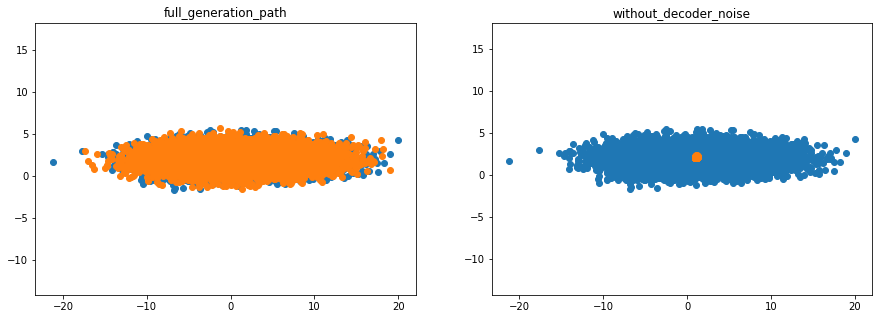

In [18]:
plot_data = train_ds_1[0:10000]
plot_samples(vae, plot_data)

### Sample 1 and scalar

--- epoch: 0 sec: 0.6953768730163574 ---
loss: 9.42434024810791 val loss: 9.056351661682129 KLD: 0.8745842576026917 val KLD: 0.7800538539886475 NLL: 8.549756050109863 val NNL: 8.276297569274902 

--- epoch: 10 sec: 0.7177274227142334 ---
loss: 3.93829607963562 val loss: 3.94224214553833 KLD: 0.04522555321455002 val KLD: 0.04183723405003548 NLL: 3.8930704593658447 val NNL: 3.900404930114746 

--- epoch: 20 sec: 0.7264981269836426 ---
loss: 3.8685786724090576 val loss: 3.955465078353882 KLD: 0.019603243097662926 val KLD: 0.02069939486682415 NLL: 3.848975419998169 val NNL: 3.934765577316284 

--- epoch: 30 sec: 0.8421351909637451 ---
loss: 3.886209011077881 val loss: 3.8777706623077393 KLD: 0.014515983872115612 val KLD: 0.015293750911951065 NLL: 3.8716931343078613 val NNL: 3.8624768257141113 

--- epoch: 40 sec: 0.8088853359222412 ---
loss: 3.866743564605713 val loss: 3.8616621494293213 KLD: 0.011600710451602936 val KLD: 0.012375468388199806 NLL: 3.855142831802368 val NNL: 3.8492867946624

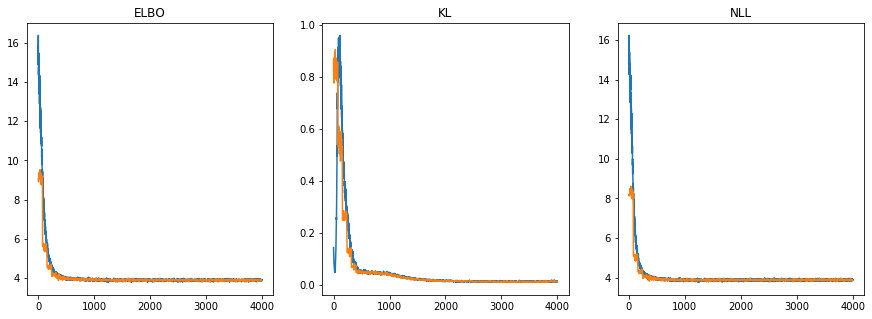

In [19]:
vae = VAE(scalar=True).to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate, weight_decay=0.0001)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae, train_loader_1, test_loader_1)
plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll)

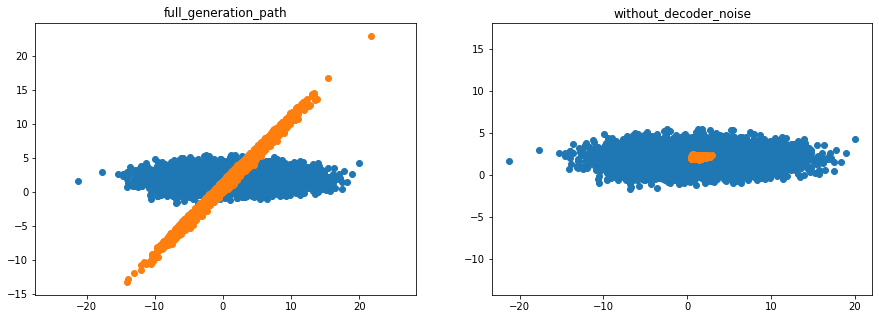

In [20]:
plot_data = train_ds_1[0:10000]
plot_samples(vae, plot_data)

### Sample 2 and no scalar

--- epoch: 0 sec: 0.7618224620819092 ---
loss: 6.780700206756592 val loss: 6.533514976501465 KLD: 0.95978844165802 val KLD: 0.9251738786697388 NLL: 5.820911884307861 val NNL: 5.608341217041016 

--- epoch: 10 sec: 0.6688125133514404 ---
loss: 3.926542282104492 val loss: 3.949490547180176 KLD: 0.15081042051315308 val KLD: 0.16392065584659576 NLL: 3.7757318019866943 val NNL: 3.785569906234741 

--- epoch: 20 sec: 0.7254462242126465 ---
loss: 3.880955934524536 val loss: 3.829401731491089 KLD: 0.09575453400611877 val KLD: 0.09210887551307678 NLL: 3.78520131111145 val NNL: 3.737292766571045 

--- epoch: 30 sec: 0.7529034614562988 ---
loss: 3.9165639877319336 val loss: 3.8728179931640625 KLD: 0.10281571745872498 val KLD: 0.10369236022233963 NLL: 3.813748359680176 val NNL: 3.7691256999969482 

--- epoch: 40 sec: 0.7534465789794922 ---
loss: 3.656475782394409 val loss: 3.638794183731079 KLD: 0.9853734374046326 val KLD: 0.9793601036071777 NLL: 2.671102285385132 val NNL: 2.6594340801239014 



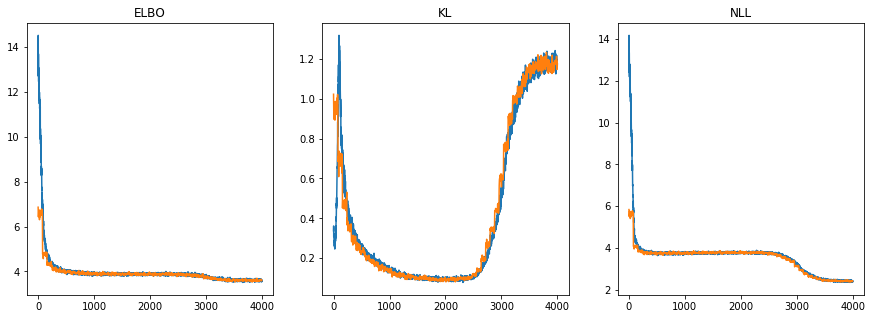

In [21]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate, weight_decay=0.0001)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae, train_loader_2, test_loader_2)
plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll)

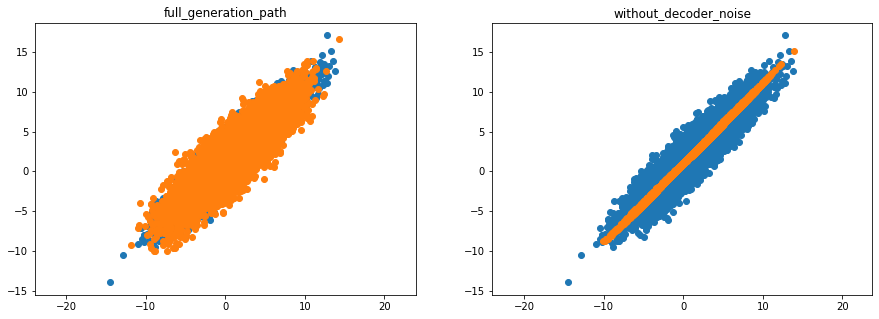

In [22]:
plot_data = train_ds_2[0:10000]
plot_samples(vae, plot_data)

### Sample 2 and scalar

--- epoch: 0 sec: 0.74288010597229 ---
loss: 6.731113433837891 val loss: 6.2648820877075195 KLD: 0.6835802793502808 val KLD: 0.6606634259223938 NLL: 6.04753303527832 val NNL: 5.604218482971191 

--- epoch: 10 sec: 0.6858134269714355 ---
loss: 3.8829288482666016 val loss: 3.8604750633239746 KLD: 0.07407382875680923 val KLD: 0.07195458561182022 NLL: 3.8088550567626953 val NNL: 3.788520574569702 

--- epoch: 20 sec: 0.7631001472473145 ---
loss: 3.887542486190796 val loss: 3.925375461578369 KLD: 0.07776417583227158 val KLD: 0.07873258739709854 NLL: 3.8097782135009766 val NNL: 3.8466429710388184 

--- epoch: 30 sec: 0.7144958972930908 ---
loss: 3.8789663314819336 val loss: 3.890854835510254 KLD: 0.0804901048541069 val KLD: 0.08286842703819275 NLL: 3.798476219177246 val NNL: 3.8079864978790283 

--- epoch: 40 sec: 0.731109619140625 ---
loss: 3.9100654125213623 val loss: 3.8598508834838867 KLD: 0.09432107210159302 val KLD: 0.07842720299959183 NLL: 3.815744400024414 val NNL: 3.781423568725586 

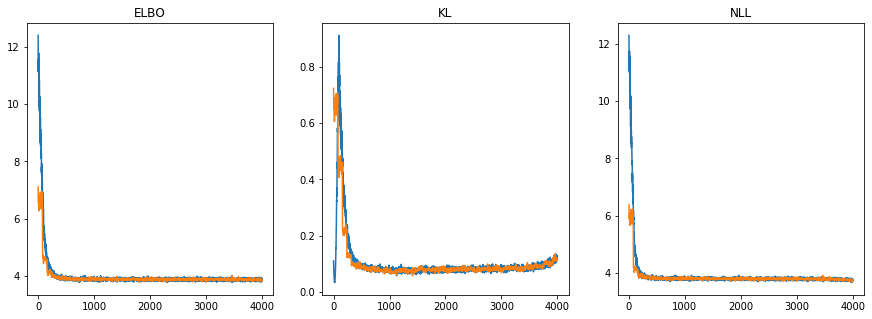

In [23]:
vae = VAE(scalar=True).to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate, weight_decay=0.0001)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae, train_loader_2, test_loader_2)
plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll)

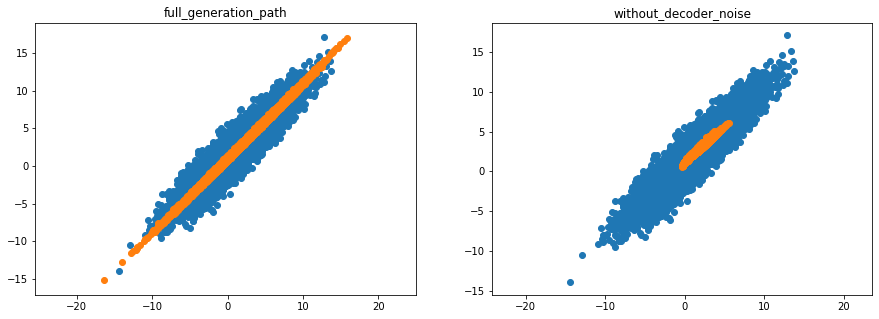

In [24]:
plot_data = train_ds_2[0:10000]
plot_samples(vae, plot_data)

# Part B

### Train a VAE with a 2-dimensional z ∼ p(z) = N(z : 0, I) and a Gaussian encoder and decoder (with diagonal covariance matrices).
## Provide these deliverables:
- Loss curves and final loss, in bits per dimension. Include separate curves and numbers
for the full ELBO, the KL term, and the decoder term; do so on the train and
validation sets. What is the
final test set performance (all three numbers)?
- Display samples.
- Display latents for data. To do so, take labeled training data (x, y) and plot z ∼
q(z|x) , colored by the label y. Comment on the appearance of the latent spaces for
the two models.
- Pick the first 100 points in the test set. Evaluate and report the IWAE objective
using 100 samples, and compare to the standard ELBO (i.e. IWAE with 1 sample).

In [0]:
def sample_data_3():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]
  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [26]:
data_3, c_data_3 =  sample_data_3()
print("Smaple data 3:", data_3.shape, "y:", c_data_3.shape)

Smaple data 3: (99999, 2) y: (99999,)


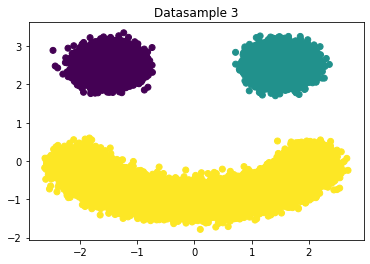

In [27]:
plt.scatter(data_3[:,0], data_3[:,1], c=c_data_3)
plt.title("Datasample 3")
plt.show()

In [0]:
data_3_train = data_3[:80000]
data_3_test = data_3[80000:]

In [0]:
train_ds_3 = MyDataset(data_3_train)
test_ds_3 = MyDataset(data_3_test)
train_loader_3 = torch.utils.data.DataLoader(train_ds_3, batch_size=BATCHSIZE, shuffle=True)
test_loader_3 = torch.utils.data.DataLoader(test_ds_3, batch_size=BATCHSIZE,shuffle=True)

In [0]:
class VAE(nn.Module):
  def __init__(self, num_samples=1, scalar=False, latent_variables=2): 
    super(VAE,self).__init__()
    
    self.latent_variables = latent_variables
    self.num_samples = num_samples
    self.scalar = scalar

    self.out_features = latent_variables + 1 if scalar else 2 * latent_variables

    self.encoder = nn.Sequential(
        nn.Linear(in_features=latent_variables, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=(self.latent_variables*2))
    )
        
    self.decoder = nn.Sequential(
        nn.Linear(in_features=self.latent_variables, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=self.out_features)
    )

  def reparametrisation(self, mu, log_var, num_samples):

    with torch.no_grad():
      batch_size = mu.size(0)
      epsilon = torch.randn(batch_size, num_samples, self.latent_variables)

    sigma = torch.exp(0.5*log_var)
        
    if len(mu.shape) < 3:
      z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)  
    else:
      z = mu + epsilon * sigma  
    return z
  
  def sample(self, z):
    if len(z.shape) < 3:
      z = z.unsqueeze(1)
    
    x_sample = self.decoder(z)
    x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
    without_decoder_noise = x_mu
    full_generation_path = self.reparametrisation(x_mu, x_log_var, 1)
    return full_generation_path, without_decoder_noise

  def log_normal(self, x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

  def loss(self, x, mu, log_var, x_mu, x_log_var):
    # print("x:", x.shape, "mu:", mu.shape, "log_var:", log_var.shape, "x_mu:", x_mu.shape, "x_log_var:", x_log_var.shape)
    x = x.unsqueeze(1)

    likelihood = torch.mean(torch.sum(-self.log_normal(x, x_mu, x_log_var), dim=2), dim=1)
  
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1))
    
    NLL = torch.mean(likelihood)/np.log(2)/2
    
    ELBO = NLL + KLD    

    return ELBO, KLD, NLL

  def forward(self, x):
    mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
    mu = mu.unsqueeze(1)
    log_var = log_var.unsqueeze(1)

    z = self.reparametrisation(mu, log_var, self.num_samples)

    x_sample = self.decoder(z)

    if self.scalar:
      x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
      x_log_var = torch.ones_like(x_mu) * x_log_var
    
    else:
      x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)

    return mu, log_var, x_mu, x_log_var

In [0]:
def train_vae(vae, train_loader, test_loader, epochs=50):
  EPOCH = epochs
  train_loss = []
  train_kld = []
  train_nll = []

  val_loss = []
  val_kld = []
  val_nll = []

  val_loss_100 = []
  val_kld_100 = []
  val_nll_100 = []

  j = 0
  for epoch in range(EPOCH):
    vae.train()
    start_time = time.time()
    for i, x in enumerate(train_loader, 0):
      x = x.to(device).float()
    
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      mu, log_var, x_mu, x_log_var = vae(x)

      loss, kld, nll = vae.loss(x, mu, log_var, x_mu, x_log_var)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      train_kld.append(kld.item())
      train_nll.append(nll.item())

    # print statistics
    
    with torch.set_grad_enabled(False):
      vae.eval()
      for val_batch in test_loader:
        x_val = val_batch.to(device).float()
        mu, log_var, x_mu, x_log_var =  vae(x_val)
        v_loss, v_kld, v_nll = vae.loss(x_val, mu, log_var, x_mu, x_log_var)

        val_loss.append(v_loss.item())
        val_kld.append(v_kld.item())
        val_nll.append(v_nll.item())
    
    with torch.set_grad_enabled(False):
      vae.eval()
      vae.num_samples = 100
      
      val_batch = next(iter(test_loader))
      val_batch = val_batch.to(device)

      x_val = val_batch.to(device).float()
      mu, log_var, x_mu, x_log_var =  vae(x_val)
      v_loss, v_kld, v_nll = vae.loss(x_val, mu, log_var, x_mu, x_log_var)

      val_loss_100.append(v_loss.item())
      val_kld_100.append(v_kld.item())
      val_nll_100.append(v_nll.item())
    
    if (epoch % 10 == 0):
      sec = (time.time() - start_time)
      print("--- epoch:", epoch, "sec:", sec, "---")
      print("loss:", loss.item(), "val loss:", v_loss.item(), 
            "KLD:", kld.item(), "val KLD:", v_kld.item(),
            "NLL:", nll.item(), "val NNL:", v_nll.item(), "\n")
  return train_loss, train_kld, train_nll, val_loss, val_kld, val_nll, val_loss_100, val_kld_100, val_nll_100

--- epoch: 0 sec: 0.7919211387634277 ---
loss: 3.0089163780212402 val loss: 3.0070300102233887 KLD: 0.08391529321670532 val KLD: 0.08195170015096664 NLL: 2.9250011444091797 val NNL: 2.9250783920288086 

--- epoch: 10 sec: 10.729809045791626 ---
loss: 1.3079187870025635 val loss: 1.303486704826355 KLD: 1.6250524520874023 val KLD: 1.616395115852356 NLL: -0.31713366508483887 val NNL: -0.31290844082832336 

--- epoch: 20 sec: 12.17997431755066 ---
loss: 0.0907588005065918 val loss: 0.051873207092285156 KLD: 4.4186320304870605 val KLD: 4.474825859069824 NLL: -4.327873229980469 val NNL: -4.422952651977539 

--- epoch: 30 sec: 15.488401174545288 ---
loss: -0.3651599884033203 val loss: -0.49562931060791016 KLD: 5.293426990509033 val KLD: 5.27522087097168 NLL: -5.6585869789123535 val NNL: -5.77085018157959 

--- epoch: 40 sec: 17.497309684753418 ---
loss: -3.078526496887207 val loss: -3.5063133239746094 KLD: 6.090153694152832 val KLD: 6.134446144104004 NLL: -9.168680191040039 val NNL: -9.640759

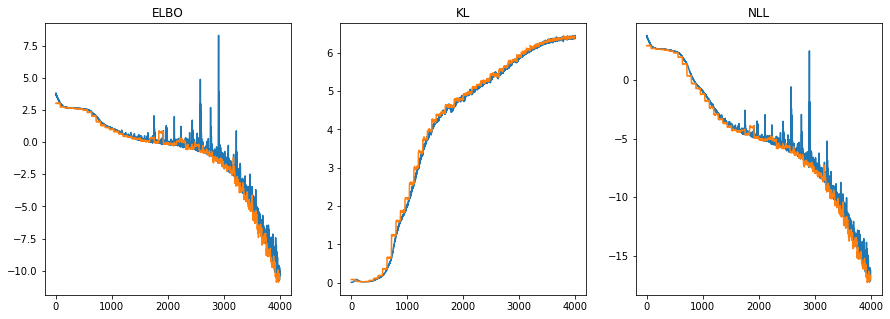

In [32]:
vae = VAE(scalar=False).to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate, weight_decay=0.0001)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll, val_loss_100, val_kld_100, val_nll_100 = train_vae(vae, train_loader_3, test_loader_3, epochs=50)
plot_loss(train_loss, val_loss, train_kld, val_kld, train_nll, val_nll)

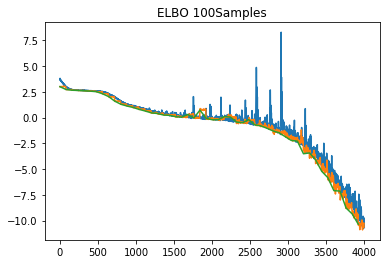

In [33]:
plt.title('ELBO 100Samples')
plt.plot(train_loss, label = "ELBO_train_loss")
plt.plot(np.arange(0, len(train_loss),(len(train_loss)/len(val_loss))),val_loss, label = "ELBO_val_loss")
plt.plot(np.arange(0, len(train_loss),(len(train_loss)/len(val_loss_100))),val_loss_100, label = "ELBO_val_loss_100")
plt.show()

In [0]:
def plot_samples_3(plot_data, c_plot_data):
  f, axarr = plt.subplots(1,2, figsize=(15,5))
  vae.eval()
  z = torch.randn(10000, 2)
  full_generation_path, without_decoder_noise = vae.sample(z)
  full_generation_path = full_generation_path.data.numpy() 
  without_decoder_noise = without_decoder_noise.data.numpy()
  mu, log_var, x_mu, x_log_var = vae.forward(plot_data.float())
  x_rec = vae.reparametrisation(x_mu, x_log_var, 1).detach().numpy()

  full_generation_path = full_generation_path.squeeze(1)
  without_decoder_noise = without_decoder_noise.squeeze(1)

  ax = axarr[0]
  ax.scatter(plot_data[:,0].data.numpy(),plot_data[:,1].data.numpy())
  ax.scatter(full_generation_path[:,0],full_generation_path[:,1],c=c_plot_data)
  ax.set_title('full_generation_path')
  ax.axis('equal')

  ax = axarr[1]
  ax.scatter(plot_data[:,0].data.numpy(),plot_data[:,1].data.numpy())
  ax.scatter(without_decoder_noise[:,0], without_decoder_noise[:,1], c=c_plot_data)
  ax.set_title('without_decoder_noise')
  ax.axis('equal')
  plt.show()

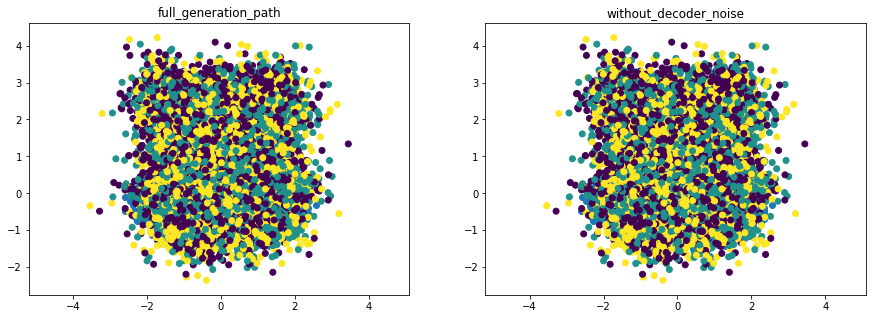

In [35]:
plot_data = train_ds_3[0:10000]
c_plot_data = c_data_3[0:10000]
plot_samples_3(plot_data, c_plot_data)